# GBM Segmentation & Thickness Estimation

In this demo we will show how to perform the segmentation of a given TEM image of GBM, performing also the thickness estimation.
This demo stores the main results of the work of Curti et al. [1](TODO) and it could be used as standalone example for the inference of new images.

The first step involves the loading of a new image.

Image shape: (1032, 1376)
Image fmt: uint8


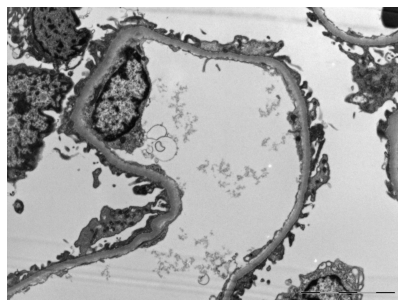

In [1]:
import numpy as np
import pylab as plt

# declare a filename
filename = 'image.tif'

# load it into a numpy array
img = plt.imread(filename)
# convert it to a simple grayscale
img = img[..., 0]

print(f'Image shape: {img.shape}')
print(f'Image fmt: {img.dtype}')

# display it
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
_ = ax.imshow(img, cmap='gray')
_ = ax.axis('off')

Then, using the `Patchifier` we will convert the full image into a series of overlapping patches (ref. [gbmseg_patchifier](https://github.com/Nico-Curti/glomerular-basement-membrane/blob/main/notebooks/gbmseg_patchifier.ipynb)), ready to use for the segmentation model (ref. [gbmseg_assl](https://github.com/Nico-Curti/glomerular-basement-membrane/blob/main/notebooks/gbmseg_assl.ipynb))

In [2]:
from Patchifier import Patchifier

PATCH_SIZE = 256
PATCH_STRIDE = 128

# copy the data to pre-process them
X = img.copy()
X = np.float32(X)
X *= 1./255

patcher = Patchifier(
    size=(PATCH_SIZE, PATCH_SIZE), 
    stride=(PATCH_STRIDE, PATCH_STRIDE), 
    pad=True
)
patcher.fit(X)
patches = patcher.transform(X)
patches.shape

(9, 11, 256, 256)

Now we have a series of images ready to be fed to a segmentation model.
The next step involves the creation of the segmentation model, loading the pre-trained set of weights obtained by the ASSL training.

In [3]:
import tensorflow as tf
from segmentation_models.model import efficientnetb3

# define the checkpoint filename
checkpoints = '../checkpoints/efficientnetb3_segmentation_round5.h5'

# define the model architecture
model = efficientnetb3(trainable=True)
inp = tf.keras.layers.Input(shape=(PATCH_SIZE, PATCH_SIZE, 1))
l1 = tf.keras.layers.Conv2D(3, (1, 1))(inp)
out = model(l1)

# build the final model
model = tf.keras.models.Model(inp, out, name=model.name)
# load the checkpoint weights
model.load_weights(checkpoints)

Segmentation Models: using `keras` framework.


Using the pre-trained model, we will generate a segmentation mask for each patch, keeping the results in floating point precision, since the inverse transformation of the patchifiers will combine them correctly into a final probability mask

In [4]:
# flat the list of patches into a unique buffer
flatten_patches = patches.reshape(-1, PATCH_SIZE, PATCH_SIZE)
# apply the model on the patches using them as batch
flatten_preds = model.predict(flatten_patches)
# reshape the patches into a matrix format
patches_preds = flatten_preds.reshape(*patches.shape)
# re-combine the patches into a unique final image inverting the transformation
pred = patcher.inverse_transform(patches_preds)

For sake of completeness, a visual inspection of the obtained result could give us an help to understand the process

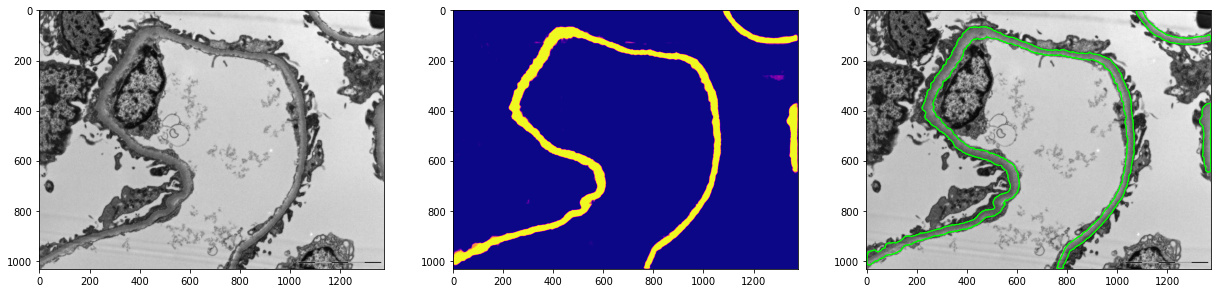

In [5]:
# binarize the prediction
mask = pred > 0.5
mask = np.uint8(mask * 255)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))
_ = ax1.imshow(img, cmap='gray')
_ = ax2.imshow(pred, cmap='plasma')
_ = ax3.imshow(img, cmap='gray')
_ = ax3.contour(mask, colors='lime', levels=1, linewidths=1)

Given the predicted membrane mask, the last step involves the estimation of its thickness in each point of its elongation.
To this purpose, the first step involves the estimation of the medial axis of the obtained shape.

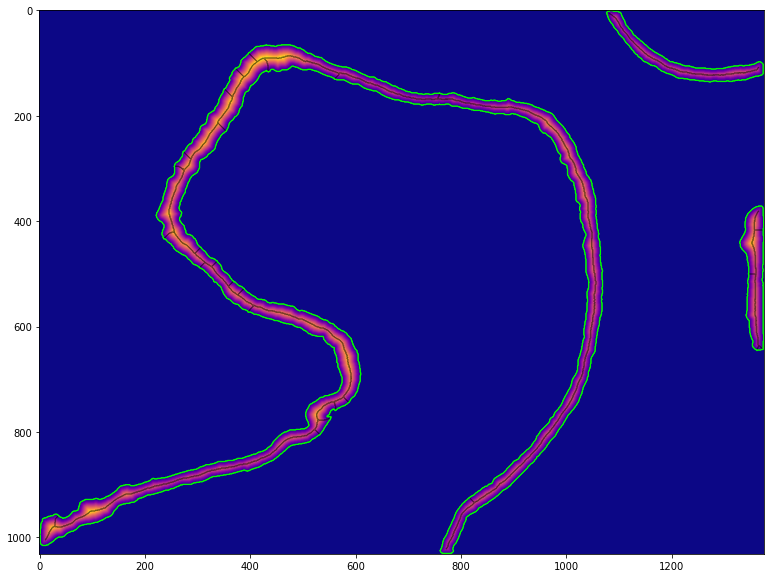

In [6]:
from skimage.morphology import medial_axis

# evaluate the medial axis keeping track of the distances
# of each point in the skeleton mask
out, dist = medial_axis(mask, return_distance=True)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 10))
_ = ax.imshow(dist, cmap='plasma')
_ = ax.contour(out, colors='k', levels=1, linewidths=0.2)
_ = ax.contour(mask, colors='lime', levels=1, linewidths=1)

Using the combination of the medial-axis mask and the distance transform map we can easily estimate the thickness of each point of the membrane, providing a full distribution of measurements collected on the entire image.

Median thickness estimation: 13.153


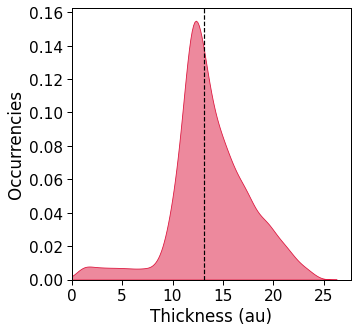

In [7]:
import seaborn as sns

thickness = dist[out != 0]
print(f'Median thickness estimation: {np.median(thickness):.3f}')

with sns.plotting_context('paper', font_scale=1.75):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    sns.kdeplot(
        x=thickness, 
        ax=ax,
        fill=True,
        alpha=0.5,
        color='crimson'
    )
    ax.axvline(np.median(thickness), linestyle='dashed', color='k')
    ax.set_xlabel('Thickness (au)')
    ax.set_ylabel('Occurrencies')
    ax.set_xlim(0, None)

# 🎉 Important updates 20/05/25 🎉

In the following cell we show the usage of the new version of the segmentation model, obtained increasing the amount of training images/patches.

The new architecture is based on a U-2-Net model (ref. [here](https://github.com/xuebinqin/U-2-Net)) and its inference is optimized using ONNX package.
Before its usage you need to install the set of required packages as:

```bash
python -m pip install onnxruntime-gpu
```

The implementation of the U-2-Net model and the related scripts can be downloaded from the main repository of the project (ref. [here](https://github.com/xuebinqin/U-2-Net/tree/master/model))

In [1]:
import torch
import onnxruntime as ort
from torch.autograd import Variable

# small version u2net 4.7 MB
from u2net_models.u2net import U2NETP

USE_ONNX = True

def normPRED(d):
    '''
    Normalize the predicted SOD probability map
    '''
    ma = torch.max(d)
    mi = torch.min(d)
    dn = (d - mi) / (ma - mi)    
    return dn

Image shape: (1032, 1376, 3)
Image fmt: uint8


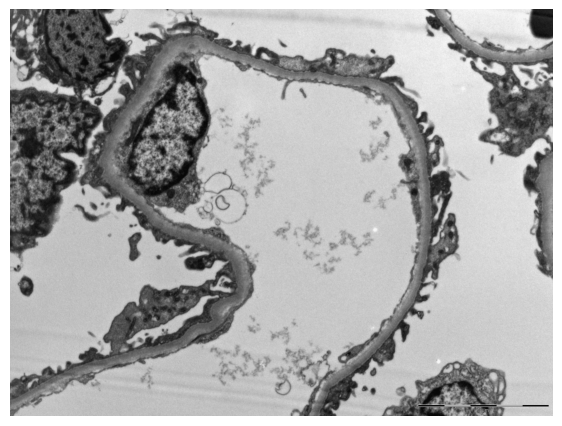

In [3]:
import numpy as np
import pylab as plt

# declare a filename
filename = 'image.tif'

# load it into a numpy array
img = plt.imread(filename)
# use it as RGB image
img = img[..., :-1]

print(f'Image shape: {img.shape}')
print(f'Image fmt: {img.dtype}')

# display it
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
_ = ax.imshow(img)
_ = ax.axis('off')

In [4]:
from Patchifier import Patchifier

PATCH_SIZE = 320
PATCH_STRIDE = 160

# copy the data to pre-process them
X = img.copy()
X = np.float32(X)
X *= 1./255
# standardize the input according
# to the U-2-Net training scaling
X[:, :, 0] = (X[:, :, 0] - 0.485) / 0.229
X[:, :, 1] = (X[:, :, 1] - 0.456) / 0.224
X[:, :, 2] = (X[:, :, 2] - 0.406) / 0.225

patcher = Patchifier(
    size=(PATCH_SIZE, PATCH_SIZE), 
    stride=(PATCH_STRIDE, PATCH_STRIDE), 
    pad=True
)
patcher.fit(X)
patches = patcher.transform(X)
patches.shape

(7, 9, 320, 320, 3)

In [15]:
if USE_ONNX:
    model_dir = '../checkpoints/u2netp_3ch.onnx'
else:
    model_dir = '../checkpoints/u2netp_3ch.pth'

net = ort.InferenceSession(model_dir) if USE_ONNX else U2NETP(in_ch=3, out_ch=1)

if not USE_ONNX:
    if torch.cuda.is_available():
        print('cuda available')
        net.load_state_dict(torch.load(model_dir))
        net.cuda()
    else:
        net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net.eval()

# flat the list of patches into a unique buffer
flatten_patches = patches.reshape(-1, PATCH_SIZE, PATCH_SIZE, 3).transpose(0, 3, 2, 1)
# convert the array to a tensor
inputs_test = torch.from_numpy(flatten_patches)

if torch.cuda.is_available():
    inputs_test = Variable(inputs_test.cuda())
else:
    inputs_test = Variable(inputs_test)

if USE_ONNX:
    # convert the input tensor to a numpy array
    inputs_test = inputs_test.cpu().numpy()    

if USE_ONNX:
    d1, d2, d3, d4, d5, d6, d7 = net.run(None, {'input': inputs_test})
else:
    d1, d2, d3, d4, d5, d6, d7 = net(inputs_test)

d1 = torch.tensor(d1)

# normalization
pred = d1[:, 0, :, :]
pred = normPRED(pred)

if torch.cuda.is_available():
    pred = pred.cpu().numpy()
pred = np.stack((pred, pred, pred), axis=1)

# reshape the patches into a matrix format
patches_preds = pred.transpose(0, 3, 2, 1).reshape(*patches.shape)
# re-combine the patches into a unique final image inverting the transformation
pred = patcher.inverse_transform(patches_preds)
# re-convert to grayscale
pred = pred[..., 0]

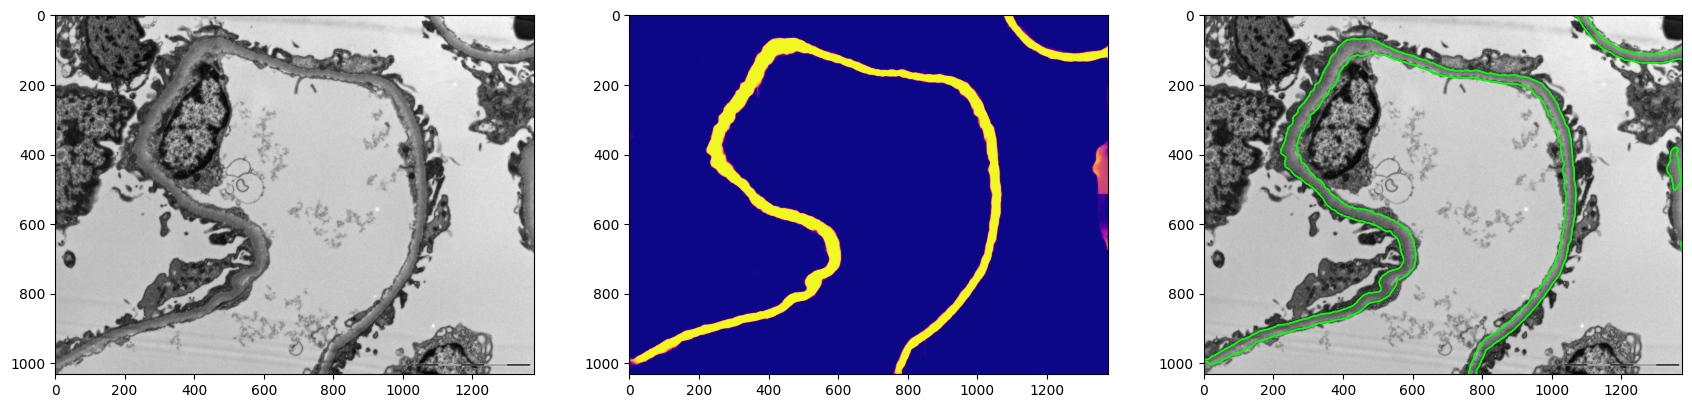

In [16]:
# binarize the prediction
mask = pred > 0.5
mask = np.uint8(mask * 255)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))
_ = ax1.imshow(img, cmap='gray')
_ = ax2.imshow(pred, cmap='plasma')
_ = ax3.imshow(img, cmap='gray')
_ = ax3.contour(mask, colors='lime', levels=1, linewidths=1)